In [1]:
import numpy as np
import pandas as pd

# Step 1: Building List and Labels

## Collecting instances from 311 calls, crimes, blight violations, and demolition permits.

Data already cleaned by [this notebook](./Cleaning_data.ipynb)
The collection of data was saved at __../data/events.csv__

In [2]:
data_events = pd.read_csv('../data/events.csv')

In [3]:
data_events.head(10)

,event_id,lon,lat,addr,type
0,0,-83.161039,42.383998,13120-13130 ilene st,1
1,1,-83.080919,42.440471,1485 e outer dr,1
2,2,-82.962038,42.445244,15460 eastburn,1
3,3,-83.166194,42.421043,17541 mendota st,1
4,4,-83.162874,42.402033,griggs,1
5,5,-83.158100,42.399431,14902 kentucky,1
6,6,-83.240740,42.439669,20089 vaughan,1
7,7,-83.053367,42.430693,18663 fenelon st,1
8,8,-83.161803,42.410764,16170 ilene st,1
9,9,-83.152779,42.437114,19530 roselawn st,1


In [4]:
data_events.shape

(453192, 5)

In [5]:
# To get rid of duplicates with same coordinates and possibly different address names
building_pool = data_events.drop_duplicates(subset=['lon','lat'])

In [6]:
building_pool.shape

(219984, 5)

In [18]:
# 1. sort data according to longitude
#    init new_data
# 2. for each record:
#        if record[lon] - prev[lon] > length:
#            add new record into new_data
#        else:
#            find previous coords that are close
#            if no coords in bbox:
#                add new record into new_data
#            else:
#                for each of these coords:
#                    if record in bbox:
#                        append event_id
#  
# At the same time, if building is assigned one permit or more for demolition, blighted will be assigned to one.
#

def gen_buildings(data):
    '''generate buildings from coordinates'''
    from assign_bbox import nearest_pos, is_in_bbox, raw_dist     # defined in assign_bbox.py in current dir
    new_data = {'addr': [], 'lon': [], 'lat': [], 'event_id_list': [], 'blighted': []}
    data_sorted = data.sort_values(by='lon', inplace=False)
    length = 4.11e-4  # longitude
    width = 2.04e-4   # latitude
    prev_lon = 0
    prev_lat = 0
    max_distX = abs(length/2)
    max_distY = abs(width/2)
    
    for i, entry in data_sorted.iterrows():
        lon = entry['lon']
        lat = entry['lat']
        b = entry['type']
        if abs(lon - prev_lon) > length:
            new_data['addr'].append(entry['addr'])
            new_data['lon'].append(lon)
            new_data['lat'].append(lat)
            # below line is different from the loop for events_part2
            new_data['event_id_list'].append([entry['event_id']])
            if b == 4:  # if demolition permit
                new_data['blighted'].append(1)
            else:
                new_data['blighted'].append(0)
            
            prev_lon = lon
            prev_lat = lat
        else:
            listX = np.array(new_data['lon'])
            listY = np.array(new_data['lat'])
            poses = nearest_pos((lon,lat), listX, listY, length, width)
            
            # if already in new_data
            if poses.size > 0:
                has_pos = False
                for pos in poses:
                    temp_lon = new_data['lon'][pos]
                    temp_lat = new_data['lat'][pos]
                    if (abs(temp_lon - lon) < max_distX) & (abs(temp_lat - lat) < max_distY):
                        new_data['event_id_list'][pos] += [entry['event_id']]
                        if b == 4:
                            new_data['blighted'][pos] = 1
                        has_pos = True
                if has_pos:
                    continue
            
            new_data['addr'].append(entry['addr'])
            new_data['lon'].append(lon)
            new_data['lat'].append(lat)
            # below line is different from the loop for events_part2
            new_data['event_id_list'].append([entry['event_id']])
            if b == 4:
                new_data['blighted'].append(1)
            else:
                new_data['blighted'].append(0)
            prev_lon = lon
            prev_lat = lat
                

    return pd.DataFrame(new_data)

In [22]:
buildings_concise = gen_buildings(building_pool)

In [23]:
buildings_concise.shape# shorter than before

(130728, 5)

In [24]:
buildings_concise.tail()

,addr,blighted,event_id_list,lat,lon
130723,"00000 kerby, grosse point farms",0,[127565],42.4139,-82.9090
130724,00400 calvin ave,0,[104873],42.4109,-82.9087
130725,00 mack and renald,0,[118910],42.4352,-82.9082
130726,"20000 mack plaza, grosse pointe woods police d...",0,"[26965, 69819]",42.4314,-82.9053
130727,20000 ballatyne court grosse pointe 48236,0,[29575],42.4219,-82.8986


In [25]:
buildings = buildings_concise

### Get rid of void coordinates

In [26]:
buildings = buildings[(buildings['lat']>42.25) & (buildings['lat']<42.5) & (buildings['lon']>-83.3) & (buildings['lon']<-82.9)]

In [27]:
buildings.shape

(130727, 5)

In [28]:
buildings['blighted'].value_counts()

0    128112
1      2615
Name: blighted, dtype: int64

## Recap of [step 0](./Building_size_estimation.ipynb)

## Adopting building coordinates
It turns out that there is a slight mismatch between real world building coordinates w.r.t given data. So that only median building dimension info is reserved from the building info we got from online open data at data.detroitmi.gov.

In [2]:
data_dir = '../data/'

In [3]:
buildings_step_0 = pd.read_csv(data_dir+'buildings_step_0.csv')
permits = pd.read_csv(data_dir+'permits.csv')

In [4]:
permits = permits[['PARCEL_NO', 'BLD_PERMIT_TYPE', 'addr', 'lon', 'lat']]

In [5]:
permits['BLD_PERMIT_TYPE'].unique()

array(['Dismantle', 'DISM'], dtype=object)

### For example: the very first entry of permit has coordinate:

In [6]:
demo01 = permits.loc[0,['PARCEL_NO','addr','lon','lat']]
print(demo01)

PARCEL_NO      2165525-6
addr         4331 barham
lon             -82.9474
lat              42.3941
Name: 0, dtype: object


### In real world data, this corresponds to:

In [7]:
c = buildings_step_0['addr'].apply(lambda x: x == permits.loc[0,'addr'])

In [8]:
buildings_step_0[c][['PARCELNO','lon','lat','addr']]

,PARCELNO,lon,lat,addr
261994,21065525-6,-82.947708,42.393997,4331 barham


The coordinate of this building from data.detroitmi.gov is slightly different from data given in our course material.

### Only building dimension info is adopted for our analysis.

In [13]:
length = 0.000411
width = 0.000204  # These results come from step 0.

In [14]:
buildings.loc[:,'llcrnrlon'] = buildings.loc[:,'lon'] - length/2
buildings.loc[:,'llcrnrlat'] = buildings.loc[:,'lat'] - width/2
buildings.loc[:,'urcrnrlon'] = buildings.loc[:,'lon'] + length/2
buildings.loc[:,'urcrnrlat'] = buildings.loc[:,'lat'] + width/2

buildings.loc[:,'building_id'] = np.arange(0,buildings.shape[0])
buildings = buildings.reindex()

In [15]:
buildings.tail()

,addr,blighted,event_id_list,lat,lon,llcrnrlon,llcrnrlat,urcrnrlon,urcrnrlat,building_id
130722,00300 neff,0,[96671],42.3845,-82.9100,-82.910206,42.384398,-82.909794,42.384602,130722
130723,"00000 kerby, grosse point farms",0,[127565],42.4139,-82.9090,-82.909205,42.413798,-82.908794,42.414002,130723
130724,00400 calvin ave,0,[104873],42.4109,-82.9087,-82.908906,42.410798,-82.908494,42.411002,130724
130725,00 mack and renald,0,[118910],42.4352,-82.9082,-82.908406,42.435098,-82.907994,42.435302,130725
130726,"20000 mack plaza, grosse pointe woods police d...",0,"[26965, 69819]",42.4314,-82.9053,-82.905506,42.431298,-82.905094,42.431502,130726


In [39]:
buildings.to_csv('../data/buildings.csv', index=False)

### Visualization

In [11]:
from bbox import draw_screen_bbox
from matplotlib import pyplot as plt
%matplotlib inline

In [12]:
buildings = pd.read_csv('../data/buildings.csv')
bboxes = buildings.loc[:,['llcrnrlon','llcrnrlat','urcrnrlon','urcrnrlat']]
bboxes = bboxes.as_matrix()

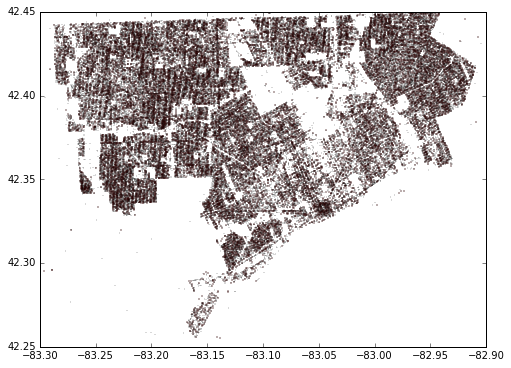

In [42]:
fig = plt.figure(figsize=(8,6), dpi=2000)
for box in bboxes:     
    draw_screen_bbox(box, fig)
    
plt.xlim(-83.3,-82.9)
plt.ylim(42.25,42.45)
plt.savefig('../data/buildings_distribution.png')
plt.show()

### Distribution of blighted buildings

In [16]:
blighted_buildings = buildings[buildings.loc[:,'blighted'] == 1]

In [17]:
blighted_bboxes = blighted_buildings.loc[:,['llcrnrlon','llcrnrlat','urcrnrlon','urcrnrlat']]
blighted_bboxes = blighted_bboxes.as_matrix()

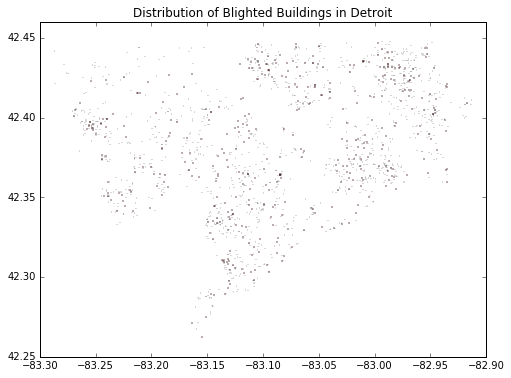

In [19]:
fig = plt.figure(figsize=(8,6), dpi=2000)
for box in blighted_bboxes:     
    draw_screen_bbox(box, fig)
    
plt.xlim(-83.3,-82.9)
plt.ylim(42.25,42.46)
plt.title("Distribution of Blighted Buildings in Detroit")
plt.savefig('../data/blighted_buildings_distribution.png')
plt.show()